In [1]:
from nudging.simulation import generate_datasets
from nudging.cate import get_cate, get_cate_correlations
from nudging.model import BiRegressor
from sklearn.linear_model import BayesianRidge
import numpy as np
from matplotlib import pyplot as plt
from nudging.cluster import KSplitPartitioner, compute_partition_correlation, KMeansPartitioner, RandomPartitioner
from scipy.stats import spearmanr
from collections import defaultdict

In [2]:
datasets = generate_datasets(500)

In [3]:
model = BiRegressor(BayesianRidge())

In [4]:
def get_cate_subgroup(model, dataset, k_split=4):
    cate_results = get_cate(model, dataset, k=5)
    cols = list(dataset.standard_df)
    cols.remove("outcome")
    cols.remove("nudge")
    pred_correct = []
    sub_true = []
    sub_pred = []
    for cate, idx in cate_results:
        for split_var in cols:
            split_vals = dataset.standard_df[split_var].iloc[idx].values
            outcomes = dataset.standard_df["outcome"].iloc[idx].values
            treatment = dataset.standard_df["nudge"].iloc[idx].values == 1
            control = np.logical_not(treatment)
            n_try = 0
            while n_try < 100:
                cur_sub_true = []
                cur_sub_pred = []

                sorted_idx = np.lexsort((np.random.randn(len(split_vals)), split_vals))
                idx_list = np.array_split(sorted_idx, k_split)
                flag = False
                for sub_idx in idx_list:
                    mask = np.zeros(len(split_vals), dtype=bool)
                    mask[sub_idx] = True
                    mask_treat = np.logical_and(mask, treatment)
                    mask_control = np.logical_and(mask, control)
                    if np.sum(mask_treat) == 0 or np.sum(mask_control) == 0:
                        flag = True
                        break
                    cur_sub_true.append(np.mean(outcomes[mask_treat])-np.mean(outcomes[mask_control]))
                    cur_sub_pred.append(np.mean(cate[sub_idx]))
                if not flag:
                    break
                n_try += 1
            if n_try == 100:
                print(split_var, np.sum(mask_treat), np.sum(mask_control), len(split_vals), np.sum(treatment), np.sum(control))
                raise ValueError("Could not find good split after 100 tries")
            sub_true.extend(cur_sub_true)
            sub_pred.extend(cur_sub_pred)
            #print(cur_sub_pred, cur_sub_true)
            corr = spearmanr(cur_sub_pred, cur_sub_true).correlation
            if np.isnan(corr):
                corr = 0
            pred_correct.append(corr)
            #idx_A = np.argsort(split_vals)[:len(split_vals)//2]
            #mask_A = np.zeros(len(split_vals), dtype=bool)
            #mask_A[idx_A] = True
            #mask_B = np.logical_not(mask_A)
            #q = np.quantile(split_vals, 0.5)
            #split_1 = split_vals > q
            #split_2 = split_vals >= q
            #if abs(np.sum(split_1)-len(split_vals)/2) <= abs(np.sum(split_2)-len(split_vals)/2):
            #    idx_A = split_1
            #else:
            #    idx_A = split_2
            #idx_B = np.logical_not(idx_A)
            #idx_A_treat = np.logical_and(mask_A, treatment)
            #idx_A_control = np.logical_and(mask_A, control)
            #idx_B_treat = np.logical_and(mask_B, treatment)
            #idx_B_control = np.logical_and(mask_B, control)
            #sub_cate_A = np.mean(outcomes[idx_A_treat]) - np.mean(outcomes[idx_A_control])
            #sub_cate_B = np.mean(outcomes[idx_B_treat]) - np.mean(outcomes[idx_B_control])
            #sub_true.extend([sub_cate_A, sub_cate_B])
            #sub_pred.extend([np.mean(cate[mask_A]), np.mean(cate[mask_B])])
            #pred_correct.append(
            #    np.sign(sub_cate_A-sub_cate_B) == np.sign(np.mean(cate[mask_A])-np.mean(cate[mask_B])))
    return spearmanr(sub_true, sub_pred).correlation, np.mean(pred_correct)



In [5]:
def plot_sub_cates(k_split=2):
    all_sub = defaultdict(lambda: [])

    for dataset in datasets:
        #sub_cate, sub_cate_spear = get_cate_subgroup(model, dataset, k_split=k_split)
        res = compute_partition_correlation(model, dataset, KSplitPartitioner, KMeansPartitioner, RandomPartitioner)
        for name in res:
            all_sub[name].append(res[name])

    for name in all_sub:
        if name == "individual":
            continue
        plt.scatter(all_sub[name], all_sub["individual"], label=name)
        print(name, spearmanr(all_sub[name], all_sub["individual"]))
    plt.legend()
    plt.show()
    
    #plt.scatter(all_sub_split, all_idv_cate)
    #plt.scatter(all_sub_kmean, all_idv_cate)
    #plt.scatter(all_sub_cate_spear, all_idv_cate)
    #plt.show()
    #print(spearmanr(all_sub_split, all_idv_cate))
    #print(spearmanr(all_sub_kmean, all_idv_cate))
    #print(spearmanr(all_sub_cate_spear, all_idv_cate))

ksplit SpearmanrResult(correlation=0.8286501626006505, pvalue=1.38646133154554e-127)
kmeans SpearmanrResult(correlation=0.7935012540050159, pvalue=1.7346308518806664e-109)
random SpearmanrResult(correlation=0.6393728294913179, pvalue=8.09867764097058e-59)
all SpearmanrResult(correlation=0.8275773583094331, pvalue=5.674738919397128e-127)


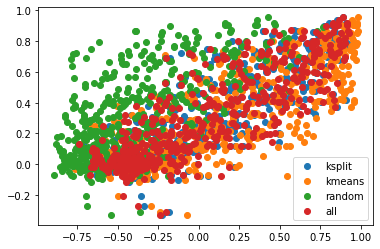

In [6]:
plot_sub_cates()

In [7]:
X, nudge, outcome = model._X_nudge_outcome(datasets[0].standard_df)

In [8]:
from sklearn.cluster import KMeans

In [9]:
km = KMeans(n_clusters=2)

In [10]:
np.unique(km.fit_predict(X), return_inverse=True)

(array([0, 1], dtype=int32), array([1, 0, 0, ..., 1, 1, 0]))

In [11]:
km.cluster_centers_

array([[ 4.21989158e+01,  5.07923269e-01,  9.21601334e-01,
         1.53961635e+00,  1.63594662e+00,  3.05689630e-02,
        -1.24207601e-02,  3.57476400e-02, -5.48033944e-02,
        -4.37491251e-01,  4.53611427e-02, -1.47820675e-01,
         1.75539254e-01,  3.40390468e-01],
       [ 5.66519405e+01,  5.06606111e-01,  9.05450041e-01,
         1.54624277e+00,  1.64203138e+00,  1.25067598e-02,
         3.78784252e-03,  3.56412138e-02,  4.86200355e-02,
         4.20589155e-01, -5.34378320e-03,  1.38309469e-01,
        -2.02758580e-01, -3.05268369e-01]])

In [12]:
X.shape

(4820, 14)

In [13]:
km.inertia_

186977.05319321534

In [14]:
class Clusters():
    def __init__(self, clusters):
        self.clusters = clusters
        self.cluster_sizes = np.unique(clusters, return_counts=True)[1]
        self.cluster_sorted = np.argsort(-self.cluster_sizes)
        self.recompute()

    def recompute(self, i_clust):
        self.cluster_sizes = np.unique(clusters, return_counts=True)[1]

        all_costs = []
        for i_other in range(i_clust+1, n_cluster):
            all_costs.append(compute_cost(i_clust, i_other))
        if len(all_costs) == 0:
            return
        self.all_costs = np.array(all_costs).T

    def compute_cost(i_src, i_dst):
        src_clust = self.cluster_sorted[i_src]
        dst_clust = self.cluster_sorted[i_dst]

        clust_mask = self.clusters == src_clust
        center = kmodel.cluster_centers_[dst_clust]
        dist_cost = np.linalg.norm(X[clust_mask] - center, axis=1)
        clust_cost = cluster_sizes[dst_clust] - cluster_sizes[src_clust] + 1
        return dist_cost + eps*clust_cost

    def swap_items(self, i_clust):
        min_costs = np.min(self.all_costs, axis=1)
        i_min_costs = np.argmin(self.all_costs, axis=1)
        swap_mask = np.sort(min_costs) + 2*eps*np.arange(len(min_costs)) < 0
        swap_idx_local = np.argsort(min_costs)[swap_mask]
        swap_idx = (np.where(self.clusters == self.cluster_sorted[i_clust])[0])[swap_idx_local]
        self.clusters.clusters[swap_idx] = i_other

    def compute_energy(self, i_clust)

def same_size_cluster(dataset, n_cluster=2, eps=0.1):
    X, nudge, outcome = model._X_nudge_outcome(dataset.standard_df)
    kmodel = KMeans(n_clusters=n_cluster)
    clusters = Clusters(kmodel.fit_predict(X))
    
    def recompute_clusters():
        cluster_sizes = np.unique(clusters, return_counts=True)[1]
        cluster_sorted = np.argsort(-cluster_sizes)

        all_costs = []
        for i_other in range(i_clust+1, n_cluster):
            all_costs.append(compute_cost(i_clust, i_other))
        if len(all_costs) == 0:
            return
        return np.array(all_costs).T

    def compute_cost(i_clust, i_other):
        clust_mask = clusters == cluster_sorted[i_clust]
        center = kmodel.cluster_centers_[cluster_sorted[i_other]]
        dist_cost = np.linalg.norm(X[clust_mask] - center, axis=1)
        clust_cost = cluster_sizes[cluster_sorted[i_other]] - cluster_sizes[cluster_sorted[i_clust]] + 1
        print("clust", clust_cost)
        return dist_cost + eps*clust_cost

    for i_clust in range(n_cluster):
        clusters.recompute_clusters(i_clust)
        clusters.swap_items(i_clust)
        all_costs = clusters.all_costs
        min_costs = np.min(all_costs, axis=1)
        i_min_costs = np.argmin(all_costs, axis=1)
        swap_mask = np.sort(min_costs) + 2*eps*np.arange(len(min_costs)) < 0
        swap_idx_local = np.argsort(min_costs)[swap_mask]
        swap_idx = (np.where(clusters == cluster_sorted[i_clust])[0])[swap_idx_local]
        self.clusters.clusters[swap_idx] = i_other    
        all_costs = recompute_clusters()

    return clusters
    zero_clust = clusters == 0
    one_clust = clusters == 1
    d_zero_one = X[zero_clust] - kmodel.cluster_centers_[1]
    d_zero_zero = X[zero_clust] - kmodel.cluster_centers_[0]
    cost = np.linalg.norm(d_zero_one, axis=1)-np.linalg.norm(d_zero_zero, axis=1)
    

SyntaxError: invalid syntax (3443221926.py, line 36)

In [ ]:
same_size_cluster(datasets[0])

In [ ]:
x = np.arange(10).reshape(-1, 1)

In [ ]:
np.min(x, axis=1)

In [ ]:
x = np.random.rand(100)

In [ ]:
np.unique(x)